In [ ]:
# import torch
# if torch.cuda.is_available():       
#     device = torch.device("cuda")
#     print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#     print('Device name:', torch.cuda.get_device_name(0))

# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

In [ ]:
!pip install wordcloud
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
%matplotlib inline
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import pandas as pd
from google.colab import drive
# Connect to google drive
drive.mount('/content/gdrive')

# Load data and set labels
#data = pickle.load(open('gdrive/My Drive/Dissertation/formspring_data.pkl', 'rb'))
df = pd.read_csv('gdrive/My Drive/Dissertation/enriched_processed_form+tweet.csv', index_col=0)

Mounted at /content/gdrive


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,39079.0,122.354948,76.555517,7.0,64.0,107.0,144.0,910.0
No_of_Words,39079.0,26.075718,16.100767,3.0,14.0,23.0,33.0,99.0
No_of_sentence,39079.0,2.058190,1.268395,1.0,1.0,2.0,3.0,30.0
label,39079.0,0.500345,0.500006,0.0,0.0,1.0,1.0,1.0
sent_length,39079.0,20.579237,13.958837,1.0,10.0,17.0,26.0,93.0


In [ ]:
df.label.value_counts()

1    19553
0    19526
Name: label, dtype: int64

There are 6 rows that has more than 40 words but they skew the data heavily. hence removing.

In [ ]:
# from ast import literal_eval
# df['Lemmatized_Text'] = df['Lemmatized_Text'].apply(lambda x: literal_eval(x))
#Creating a corpus of text feature to encode further into vectorized form
# corpus= []
# for i in df["Lemmatized_Text"]:
#     txt = ' '.join([row for row in i])
#     corpus.append(txt)

In [ ]:
X = df['clean_text']
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40, stratify=y)

In [ ]:
y_train.value_counts()

1    17598
0    17573
Name: label, dtype: int64

In [ ]:
X_train.values

array(['hey you know that smurfet is the only female smurf do you think shes hoe nah',
       'did even watch the full video the indian man steped right into the crowd the boys didnt do anything except claims harasment after black kid said jesus was black dont say white bois white and friends with tons of colored whatchu got up rn is racism',
       'am down facebok friends since yesterday i have not checked the twitter count that is fine in high schol ached to be the popular girl was very much not was bullied every single day for being unapologeticaly myself just for being me',
       ...,
       'swear some people who support trump are legit brainwashed on the other side no wonder they can convince christian conservatives to kill christians in the middle east fund radical islam they sneak you you eat it up some of you are really that easy to manipulate',
       'honestly think the roles of high school are going to completely change in the future kids will be bullied for being homopho

In [ ]:
sentences = X_train.values
labels = y_train.values

In [ ]:
len(labels)

35171

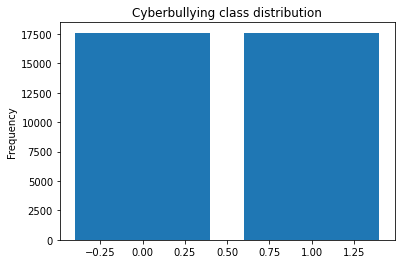

In [ ]:
plt.bar(y_train.value_counts().index, y_train.value_counts())
plt.title("Cyberbullying class distribution")
plt.ylabel("Frequency")
plt.show()

# Tokenization & Input Formatting

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 8.9 MB/s 
     |████████████████████████████████| 182 kB 73.0 MB/s 
     |████████████████████████████████| 7.6 MB 48.9 MB/s 


## BERT Tokenizer

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  hey you know that smurfet is the only female smurf do you think shes hoe nah
Tokenized:  ['hey', 'you', 'know', 'that', 'sm', '##ur', '##fe', '##t', 'is', 'the', 'only', 'female', 'sm', '##ur', '##f', 'do', 'you', 'think', 'she', '##s', 'ho', '##e', 'nah']
Token IDs:  [4931, 2017, 2113, 2008, 15488, 3126, 7959, 2102, 2003, 1996, 2069, 2931, 15488, 3126, 2546, 2079, 2017, 2228, 2016, 2015, 7570, 2063, 20976]


##Tokenize Dataset

In [ ]:
# Find maximum length based on our dataset
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  143


In [ ]:
"""Perform required preprocessing steps for pretrained BERT.
@param    data (np.array): Array of texts to be processed.
@return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
@return   attention_masks (torch.Tensor): Tensor of indices specifying which
              tokens should be attended to by the model.
"""
# Create empty lists to store outputs
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #    (1) Tokenize the sentence
    #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
    #    (3) Truncate/Pad sentence to max length
    #    (4) Map tokens to their IDs
    #    (5) Create attention mask
    #    (6) Return a dictionary of outputs
    encoded_sent = tokenizer.encode_plus(
        text=sent,  # Preprocess sentence
        add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
        max_length=150,             # Max length to truncate/pad
        pad_to_max_length=True,         # Pad sentence to max length
        return_attention_mask=True,      # Return attention mask
        truncation = True
        )
    # Add the outputs to the lists
    input_ids.append(encoded_sent.get('input_ids'))
    attention_masks.append(encoded_sent.get('attention_mask'))
# Convert lists to tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

In [ ]:
labels.size()

torch.Size([35171])

In [ ]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

Original:  hey you know that smurfet is the only female smurf do you think shes hoe nah
Token IDs: tensor([  101,  4931,  2017,  2113,  2008, 15488,  3126,  7959,  2102,  2003,
         1996,  2069,  2931, 15488,  3126,  2546,  2079,  2017,  2228,  2016,
         2015,  7570,  2063, 20976,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 

## Training & Validation Split

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# # Calculate the number of samples to include in each set.
# train_size = int(0.9 * len(dataset))
# val_size = len(dataset) - train_size

# # Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} Total training samples'.format(len(dataset)))
# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))

35,171 Total training samples


In [ ]:
train_labels = []
for i in range(len(dataset)):
  train_labels.append(dataset[i][2])

In [ ]:
class_sample_count = np.unique(train_labels, return_counts=True)[1]

In [ ]:
class_sample_count

array([17573, 17598])

In [ ]:
from torch.utils.data import WeightedRandomSampler

weight = 1. / class_sample_count
samples_weight = weight[train_labels]
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = sampler, # Select batches based on weights
            batch_size = batch_size # Trains with this batch size.
        )

# # For validation the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

# Train Our Classification Model

Now that our input data is properly formatted, it’s time to fine tune the BERT model.

## BertForSequenceClassification

We’ll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

In the below cell, I’ve printed out the names and dimensions of the weights for:

The embedding layer.
The first of the twelve transformers.
The output layer.

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

##Optimizer & Learning Rate Scheduler

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):
Batch size: 16, 32; 
Learning rate (Adam): 5e-5, 3e-5, 2e-5; 
Number of epochs: 2, 3, 4

We have chosen:

Batch size: 32 (set when creating our DataLoaders);
Learning rate: 2e-5;
Epochs: 4 (we’ll see that this is probably too many…)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

Training:

Unpack our data inputs and labels
Load data onto the GPU for acceleration
Clear out the gradients calculated in the previous pass.
In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
Forward pass (feed input data through the network)
Backward pass (backpropagation)
Tell the network to update parameters with optimizer.step()
Track variables for monitoring progress

Evaluation:
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Forward pass (feed input data through the network)
Compute loss on our validation data and track variables for monitoring progress

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import gc
gc.collect()

36

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

type(device)

torch.device

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        tmp = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss, logits = tmp[0], tmp[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # print("")
    # print("Running Validation...")

    # t0 = time.time()

    # # Put the model in evaluation mode--the dropout layers behave differently
    # # during evaluation.
    # model.eval()

    # # Tracking variables 
    # total_eval_accuracy = 0
    # total_eval_loss = 0
    # nb_eval_steps = 0

    # # Evaluate data for one epoch
    # for batch in validation_dataloader:
        
    #     # Unpack this training batch from our dataloader. 
    #     #
    #     # As we unpack the batch, we'll also copy each tensor to the GPU using 
    #     # the `to` method.
    #     #
    #     # `batch` contains three pytorch tensors:
    #     #   [0]: input ids 
    #     #   [1]: attention masks
    #     #   [2]: labels 
    #     b_input_ids = batch[0].to(device)
    #     b_input_mask = batch[1].to(device)
    #     b_labels = batch[2].to(device)
        
    #     # Tell pytorch not to bother with constructing the compute graph during
    #     # the forward pass, since this is only needed for backprop (training).
    #     with torch.no_grad():        

    #         # Forward pass, calculate logit predictions.
    #         # token_type_ids is the same as the "segment ids", which 
    #         # differentiates sentence 1 and 2 in 2-sentence tasks.
    #         # The documentation for this `model` function is here: 
    #         # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    #         # Get the "logits" output by the model. The "logits" are the output
    #         # values prior to applying an activation function like the softmax.
    #         temp = model(b_input_ids, 
    #                                token_type_ids=None, 
    #                                attention_mask=b_input_mask,
    #                                labels=b_labels)
    #         (loss, logits) = temp[0], temp[1]
            
    #     # Accumulate the validation loss.
    #     total_eval_loss += loss.item()

    #     # Move logits and labels to CPU
    #     logits = logits.detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()

    #     # Calculate the accuracy for this batch of test sentences, and
    #     # accumulate it over all batches.
    #     total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # # Report the final accuracy for this validation run.
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # # Calculate the average loss over all of the batches.
    # avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # # Measure how long the validation run took.
    # validation_time = format_time(time.time() - t0)
    
    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,199.    Elapsed: 0:00:17.
  Batch    80  of  2,199.    Elapsed: 0:00:34.
  Batch   120  of  2,199.    Elapsed: 0:00:51.
  Batch   160  of  2,199.    Elapsed: 0:01:08.
  Batch   200  of  2,199.    Elapsed: 0:01:24.
  Batch   240  of  2,199.    Elapsed: 0:01:41.
  Batch   280  of  2,199.    Elapsed: 0:01:58.
  Batch   320  of  2,199.    Elapsed: 0:02:15.
  Batch   360  of  2,199.    Elapsed: 0:02:32.
  Batch   400  of  2,199.    Elapsed: 0:02:48.
  Batch   440  of  2,199.    Elapsed: 0:03:05.
  Batch   480  of  2,199.    Elapsed: 0:03:22.
  Batch   520  of  2,199.    Elapsed: 0:03:39.
  Batch   560  of  2,199.    Elapsed: 0:03:56.
  Batch   600  of  2,199.    Elapsed: 0:04:13.
  Batch   640  of  2,199.    Elapsed: 0:04:29.
  Batch   680  of  2,199.    Elapsed: 0:04:46.
  Batch   720  of  2,199.    Elapsed: 0:05:03.
  Batch   760  of  2,199.    Elapsed: 0:05:20.
  Batch   800  of  2,199.    Elapsed: 0:05:36.
  Batch   840  of

In [ ]:
torch.save(model, 'gdrive/My Drive/Dissertation/enriched_form+tweet_Bertmodel')
saved_model = torch.load('gdrive/My Drive/Dissertation/enriched_form+tweet_Bertmodel')

In [ ]:
type(saved_model)

transformers.models.bert.modeling_bert.BertForSequenceClassification

Let’s view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Time
epoch,,
1,0.28,0:15:22
2,0.20,0:15:21
3,0.16,0:15:21
4,0.14,0:15:21


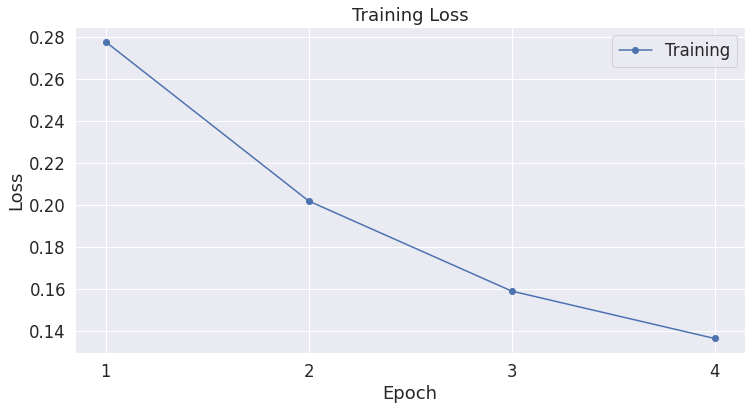

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
#plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#Performance On Test Set

In [ ]:
pred_sentences = X_test.values
y_true = y_test.values

In [ ]:
len(pred_sentences)

3908

In [ ]:
"""Perform required preprocessing steps for pretrained BERT.
@param    data (np.array): Array of texts to be processed.
@return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
@return   attention_masks (torch.Tensor): Tensor of indices specifying which
              tokens should be attended to by the model.
"""
# Create empty lists to store outputs
t_input_ids = []
t_attention_masks = []

# For every sentence...
for s in pred_sentences:
    # `encode_plus` will:
    #    (1) Tokenize the sentence
    #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
    #    (3) Truncate/Pad sentence to max length
    #    (4) Map tokens to their IDs
    #    (5) Create attention mask
    #    (6) Return a dictionary of outputs
    p_encoded_sent = tokenizer.encode_plus(
        text=s,  # Preprocess sentence
        add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
        max_length=128,             # Max length to truncate/pad
        pad_to_max_length=True,         # Pad sentence to max length
        return_attention_mask=True,      # Return attention mask
        truncation = True
        )
    # Add the outputs to the lists
    t_input_ids.append(p_encoded_sent.get('input_ids'))
    t_attention_masks.append(p_encoded_sent.get('attention_mask'))
# Convert lists to tensors
t_input_ids = torch.tensor(t_input_ids)
t_attention_masks = torch.tensor(t_attention_masks)
t_labels = torch.tensor(y_true)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
t_input_ids.size()

torch.Size([3908, 128])

In [ ]:
from torch.utils.data import TensorDataset

# Combine the training inputs into a TensorDataset.
prediction_data = TensorDataset(t_input_ids, t_attention_masks, t_labels)

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16
# For Prediction the order doesn't matter, so we'll just read them sequentially.
prediction_dataloader = DataLoader(
            prediction_data, # The test samples.
            sampler = SequentialSampler(prediction_data), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Evaluate on Test set

In [ ]:
import torch
from google.colab import drive
# Connect to google drive
drive.mount('/content/gdrive')
model = torch.load('gdrive/My Drive/Dissertation/enriched_form+tweet_Bertmodel')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_data)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,908 test sentences...
    DONE.


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

Accuracy: 85.72%
F1 score: 85.68%
Precision: 85.95%
Recall: 85.42%
Accuracy 0.86


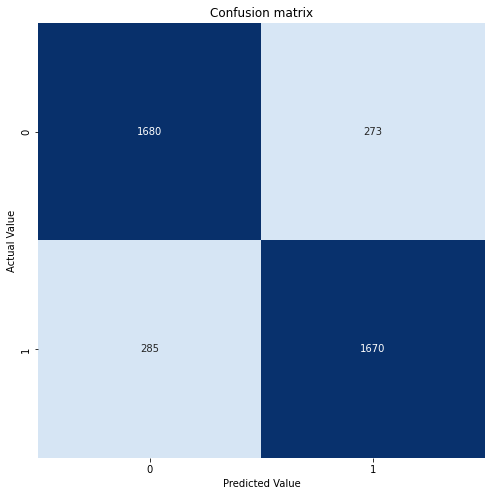

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1953
           1       0.86      0.85      0.86      1955

    accuracy                           0.86      3908
   macro avg       0.86      0.86      0.86      3908
weighted avg       0.86      0.86      0.86      3908



In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')
f1 = f1_score(flat_true_labels, flat_predictions)
print(f'F1 score: {f1*100:.2f}%')
precision = precision_score(flat_true_labels, flat_predictions)
print(f'Precision: {precision*100:.2f}%')
recall = recall_score(flat_true_labels, flat_predictions)
print(f'Recall: {recall*100:.2f}%')

c_matrix =confusion_matrix(flat_true_labels,flat_predictions)
clr = classification_report(flat_true_labels,flat_predictions)
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print("Accuracy", round(accuracy,2) )
plt.figure(figsize=(8,8))
sns.heatmap(c_matrix,annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Confusion matrix")
plt.show()
print(clr)

AUC: 0.8572


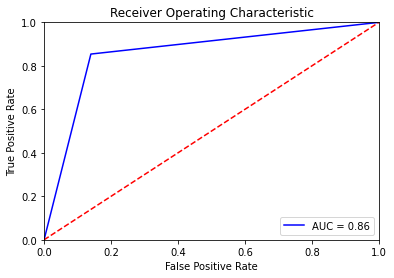

In [ ]:
fpr, tpr, threshold = roc_curve(flat_true_labels,flat_predictions)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')


# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.714
